# Bag of Words and Tf-Idf
## Part 2 of the Workshop "Text Classification - From Zero to Hero", by Dr. Omri Allouche, Gong.io, Bar Ilan University
In this notebook, we perform a very basic EDA (Exploratory Data Analysis) of the dataset, and build a basic classifier using Tf-Idf encoding.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["axes.labelsize"] = 15

In [105]:
df = pd.read_csv('data/train.csv')
df.head()

,label,text,num_chars
0,talk.politics.mideast,^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ^^^^^^^^^...,380
1,rec.sport.baseball,"probably because everyone (that is, everyone w...",352
2,talk.politics.mideast,[deleted] it's noteworthy that the posts about...,303
3,rec.sport.hockey,wood played most of his junior career in seatt...,337
4,talk.politics.mideast,the litani river flows in a west-southwestern ...,314


In [106]:
df['label'].value_counts()

rec.sport.hockey         101
rec.sport.baseball        91
talk.politics.guns        90
talk.politics.mideast     85
Name: label, dtype: int64

Now let's fit a Tf-Idf vectorizer to these documents. We'll remove English stopwords, and check the words that have the highest Tfidf score for each class:

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

df_train = pd.read_csv('data/train.csv')
vectors = vectorizer.fit_transform(df_train['text'])
vectors.shape

(367, 4021)

In [108]:
df_train['tfidf'] = list(vectors.toarray())

In [109]:
inverse_vocab = {v: k for k,v in vectorizer.vocabulary_.items()}
top_terms = df_train.groupby('label')['tfidf'].apply(lambda x: x.sum(axis=0))
for i,r in top_terms.iteritems():
    print(i)
    print([inverse_vocab[x] for x in np.argsort(r)[-20:][::-1]])
    print()

rec.sport.baseball
['don', 'team', 'think', 'good', 'baseball', 'day', 'mail', 'game', 'know', 'year', 'hit', 'ball', 'win', 'list', 'time', 'pretty', 'did', 'players', 'braves', 'games']

rec.sport.hockey
['game', 'espn', 'games', 'team', 'don', 'hockey', 'year', 'good', 'caps', 'time', 'like', 'season', 'know', 'just', 'blues', 'hawks', 'playoffs', 'sure', 'buffalo', 'wings']

talk.politics.guns
['fbi', 'gun', 'compound', 'just', 'people', 'com', 'batf', 'children', 'government', 'bd', 'like', 'know', 'did', 'weapons', 'feustel', 'gas', 'waco', 'control', 'law', 'tell']

talk.politics.mideast
['israel', 'jews', 'people', 'think', 'just', 'israeli', 'arabs', 'arab', 'does', 'don', 'peace', 'like', 'need', 'kill', 'west', 'palestinian', 'calling', 'article', 'say', 'anti']



### Basic Classifier
Next, let's build a basic classifier. Let's use the Multinomial Naive Bayes.

We'll first fit the model on the train set:

In [149]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import metrics

# We use the vectorizer we fitted earlier to transform the textual string into 
vectors = vectorizer.transform(df_train['text'])
vectors = vectors.toarray()
clf = MultinomialNB()
clf.fit(vectors, df_train['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

And then predict and evaluate performance on the validation set:

In [150]:
df['label'].value_counts()

rec.sport.hockey         101
rec.sport.baseball        91
talk.politics.guns        90
talk.politics.mideast     85
Name: label, dtype: int64

In [151]:
df_val = pd.read_csv('data/val.csv')
y_truth = df_val['label']
vectors_val = vectorizer.transform(df_val['text'])
vectors_val = vectors_val.toarray()
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [152]:
metrics.f1_score(y_truth, y_predict, average='macro')

0.7546265328874024

We see that even a simple model performs pretty well. Let's examine the most important features for each class:

In [153]:
def show_top_terms(classifier, vectorizer):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i in range(len(classifier.classes_)):
        top_terms = np.argsort(classifier.coef_[i])[-20:]
        print(classifier.classes_[i])
        print(", ".join(feature_names[top_terms]))
        print()

show_top_terms(clf, vectorizer)

rec.sport.baseball
games, braves, players, did, pretty, time, list, win, ball, hit, year, know, game, mail, day, baseball, good, think, team, don

rec.sport.hockey
wings, buffalo, sure, playoffs, hawks, blues, just, know, season, like, time, caps, good, year, hockey, don, team, games, espn, game

talk.politics.guns
tell, law, control, waco, gas, feustel, weapons, did, know, like, bd, government, children, batf, com, people, just, compound, gun, fbi

talk.politics.mideast
anti, say, article, calling, palestinian, west, kill, need, like, peace, don, does, arab, arabs, israeli, just, think, people, jews, israel



Let's further examine the classification report and the confusion matrix:

In [154]:
from model_evaluation_utils import *

In [155]:
from sklearn import metrics
print(metrics.classification_report(y_truth, y_predict))

                       precision    recall  f1-score   support

   rec.sport.baseball       0.73      0.53      0.62        15
     rec.sport.hockey       0.64      1.00      0.78        18
   talk.politics.guns       0.78      0.82      0.80        22
talk.politics.mideast       1.00      0.70      0.82        23

            micro avg       0.77      0.77      0.77        78
            macro avg       0.79      0.76      0.75        78
         weighted avg       0.80      0.77      0.77        78



Normalized confusion matrix
[[0.53333333 0.33333333 0.13333333 0.        ]
 [0.         1.         0.         0.        ]
 [0.04545455 0.13636364 0.81818182 0.        ]
 [0.08695652 0.08695652 0.13043478 0.69565217]]


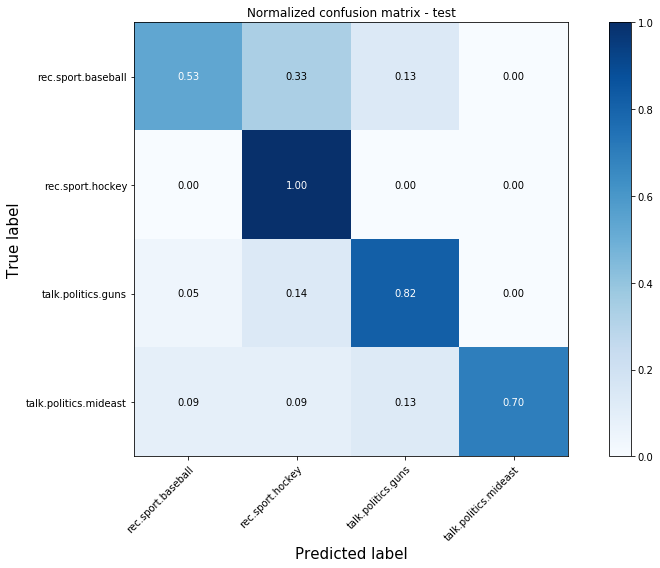

In [156]:
plot_confusion_matrix(y_truth, y_predict, normalize=True, title='Normalized confusion matrix - test');

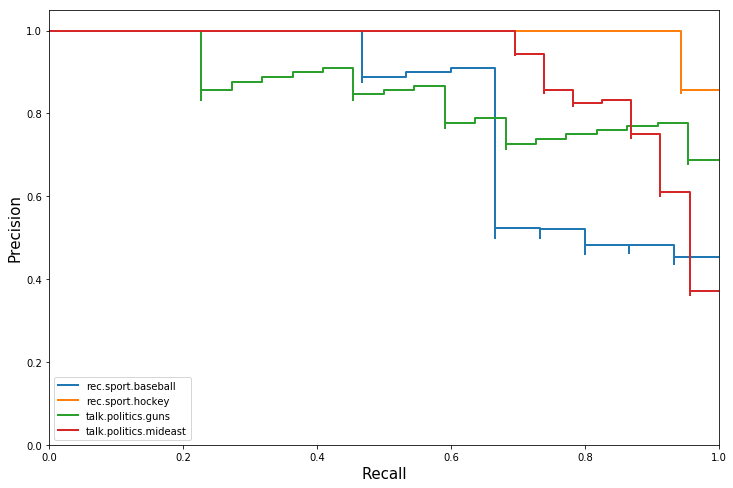

In [157]:
plot_precision_recall_curve(y_predict_proba, y_truth);

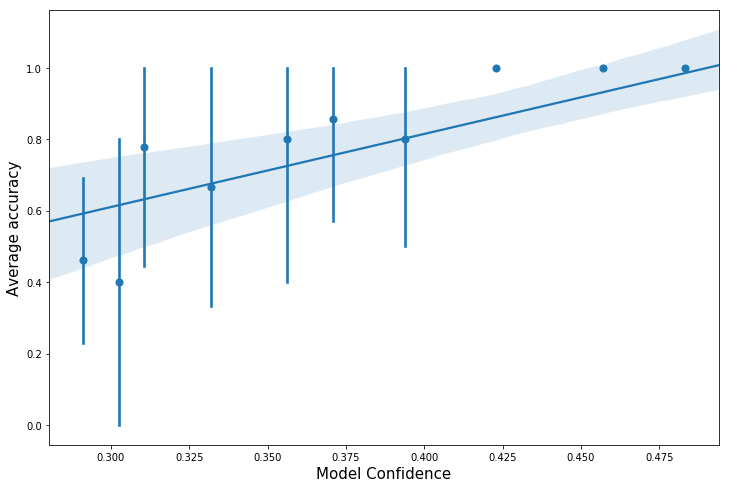

In [158]:
plot_confidence_performance(y_predict, y_predict_proba, y_truth, num_bins=10);

Next, let's perform an error analysis and manually review documents that are wrongly classified. We will focus on documents that have a high model confidence:

In [159]:
df_test = pd.read_csv('data/val.csv')
y_truth = df_test['label']
vectors_val = vectorizer.transform(df_val['text'])
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [160]:
df_test['y_predict'] = clf.predict(vectors_val)
df_test['y_predict_proba'] = np.max(clf.predict_proba(vectors_val), axis=1)
df_test['is_error'] = (y_predict != y_truth).astype(int)

In [161]:
df_test.sort_values('is_error', ascending=False).head()

,label,text,num_chars,y_predict,y_predict_proba,is_error
0,rec.sport.baseball,"oh. i forgot. art shamsky, former red and mets...",203,rec.sport.hockey,0.337270,1
66,talk.politics.mideast,"why do you title this ""news you will miss"" ? t...",267,talk.politics.guns,0.313678,1
49,rec.sport.baseball,"well, there were 27 outs in a row with no hits...",308,rec.sport.hockey,0.370528,1
36,talk.politics.guns,did anyone notice any helicopters equipped wit...,200,rec.sport.baseball,0.296303,1
35,rec.sport.baseball,": it's i before e except after c, and in peopl...",237,rec.sport.hockey,0.292334,1


In [162]:
def print_document(r):    
    print('Document #{}. \nTrue label: {}. \nPredicted: {} (confidence: {:.1%})'.format(
        r.name,
        r['label'], 
        r['y_predict'],
        r['y_predict_proba']
    ))
    print()
    print(r['text'])

In [163]:
from ipywidgets import interact

@interact(i=(0,len(df_test)))
def explore_doc(i):
    print_document(df_test.iloc[i])

interactive(children=(IntSlider(value=39, description='i', max=78), Output()), _dom_classes=('widget-interact'…

(0, 600)

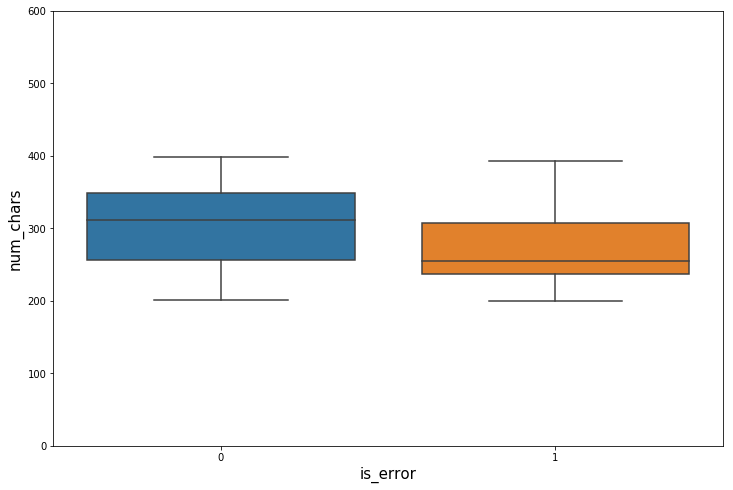

In [164]:
sns.boxplot(data=df_test, x='is_error', y='num_chars')
plt.ylim(0,600)

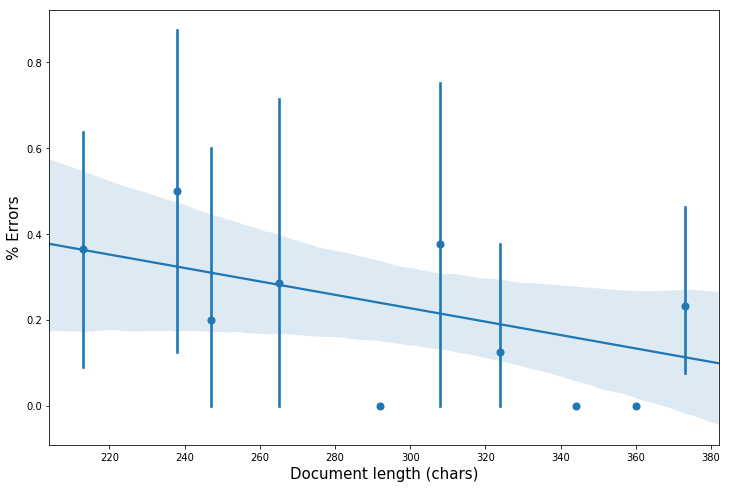

In [165]:
ax = sns.regplot(data=df_test, x='num_chars', y=df_test['is_error'], x_bins=10)
plt.xlabel('Document length (chars)');
plt.ylabel('% Errors');